1. ***Beskriv kort hur en relationsdatabas fungerar.***  
    -- En databas där tabeller och data är relaterade till varandra.  
2. ***Vad menas med ”CRUD” flödet?***  
    -- Create  
    -- Read  
    -- Update  
    -- Delete  
    -- Dem olika metoderna vi använder för att skapa och hantera relationsdatabaser  
3. ***Beskriv kort vad en ”left join” och ”inner join” är. Varför använder man det?***  
    -- Left Join är där vi kombinerar två tabeller där vi bevarar all data från den   
    -- vänstra tabellen men bara det som har matchande data i högra tabellen.  
    -- En Inner Join är där vi kombinerar två tabeller men bevarar bara dem raderna  
    -- som har matchande data i båda tabellerna.
4. ***Beskriv kort vad indexering i SQL innebär.***  
    -- Indexering hjälper oss att kolla upp data i databasen snabbare. Den vanligaste  
    -- typen av index i sql skapas automatiskt när vi bestämmer vad som är primary key  
    -- i en tabell.  
5. ***Beskriv kort vad en vy i SQL är.***  
    -- En vy är en virituell tabell baserad på "riktiga" tabeller. Det är alltså en  
    -- sparad SELECT call som kallar på tabeller utan att lagradatan på nytt.  
6. ***Beskriv kort vad en lagrad procedur i SQL är.***  
    -- En lagrad procedur är en sparad kod som går att kalla på flera gånger  
    -- utan att behöva skriva hela koden igen.  

In [8]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def new_engine(dialect, server, database, user=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f'{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server'
    else:
        # For SQL Server authentication
        eng = f'{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
    print(eng)
    return create_engine(eng)

In [10]:
engine = new_engine('mssql', 'SAURON', 'AdventureWorks2022', integrated_security=True)
connection = engine.connect()

mssql://SAURON/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [11]:
# Total försäljning, kostnad och vinst
query1 = """
WITH AvgCostPerItem
AS
(
	SELECT ProductID
		, AVG(StandardCost) AS AverageCost
	FROM Production.ProductCostHistory
	GROUP BY ProductID
)

SELECT ROUND(SUM(C.TotalDue), 2) AS TotalSales
	, ROUND(SUM(A.OrderQty * B.AverageCost), 2) AS TotalProductionCost
	, ROUND(70479332.64, 2) as TotalPurchaseCost
	, ROUND((SUM(A.OrderQty * B.AverageCost) + 70479332.64), 2) AS TotalCost
	, ROUND(SUM(C.TotalDue) - (SUM(A.OrderQty * B.AverageCost) + 70479332.64), 2) AS TotalProfit
FROM Sales.SalesOrderDetail AS A
	INNER JOIN AvgCostPerItem AS B
		ON A.ProductID = B.ProductID
	INNER JOIN Sales.SalesOrderHeader AS C
		ON A.SalesOrderID = C.SalesOrderID;
"""

df = pd.read_sql(sql=query1, con=connection)

In [12]:
df

,TotalSales,TotalProductionCost,TotalPurchaseCost,TotalCost,TotalProfit
0,2.926970e+09,96957586.44,70479332.64,1.674369e+08,2.759533e+09


In [13]:
# Info om anställda
employee = """
SELECT EPH.BusinessEntityID
	, CONCAT(P.FirstName, ' ', P.LastName) AS Name
	, E.JobTitle
	, ED.Department
	, E.BirthDate
	, MaritalStatus
	, Gender
	, E.HireDate
	, P.PersonType
	, vE.CountryRegionName AS Country
	, MAX(EPH.Rate) AS Rate
	, MAX(EPH.Rate) * 160 AS MonthlyPay
FROM HumanResources.EmployeePayHistory AS EPH
	INNER JOIN HumanResources.Employee AS E
		ON EPH.BusinessEntityID = E.BusinessEntityID
	INNER JOIN Person.Person AS P
		ON E.BusinessEntityID = P.BusinessEntityID
	INNER JOIN HumanResources.vEmployeeDepartment AS ED
		ON EPH.BusinessEntityID = ED.BusinessEntityID
	INNER JOIN HumanResources.vEmployee AS vE
		ON E.BusinessEntityID = vE.BusinessEntityID
GROUP BY EPH.BusinessEntityID
	, CONCAT(P.FirstName, ' ', P.LastName)
	, E.JobTitle
	, ED.Department
	, E.BirthDate
	, MaritalStatus
	, Gender
	, E.HireDate
	, P.PersonType
	, vE.CountryRegionName
ORDER BY MonthlyPay DESC;
"""

employeedf = pd.read_sql(sql=employee, con=connection)

In [14]:
employeedf.head()

,BusinessEntityID,Name,JobTitle,Department,BirthDate,MaritalStatus,Gender,HireDate,PersonType,Country,Rate,MonthlyPay
0,1,Ken Sánchez,Chief Executive Officer,Executive,1969-01-29,S,M,2009-01-14,EM,United States,125.5000,20080.000
1,25,James Hamilton,Vice President of Production,Production,1983-01-07,S,M,2009-02-03,EM,United States,84.1346,13461.536
2,273,Brian Welcker,Vice President of Sales,Sales,1977-06-06,S,M,2011-02-15,EM,United States,72.1154,11538.464
3,2,Terri Duffy,Vice President of Engineering,Engineering,1971-08-01,S,F,2008-01-31,EM,United States,63.4615,10153.840
4,234,Laura Norman,Chief Financial Officer,Executive,1976-01-06,M,F,2009-01-31,EM,United States,60.0962,9615.392


Text(0.5, 1.0, 'Average hourly pay per department')

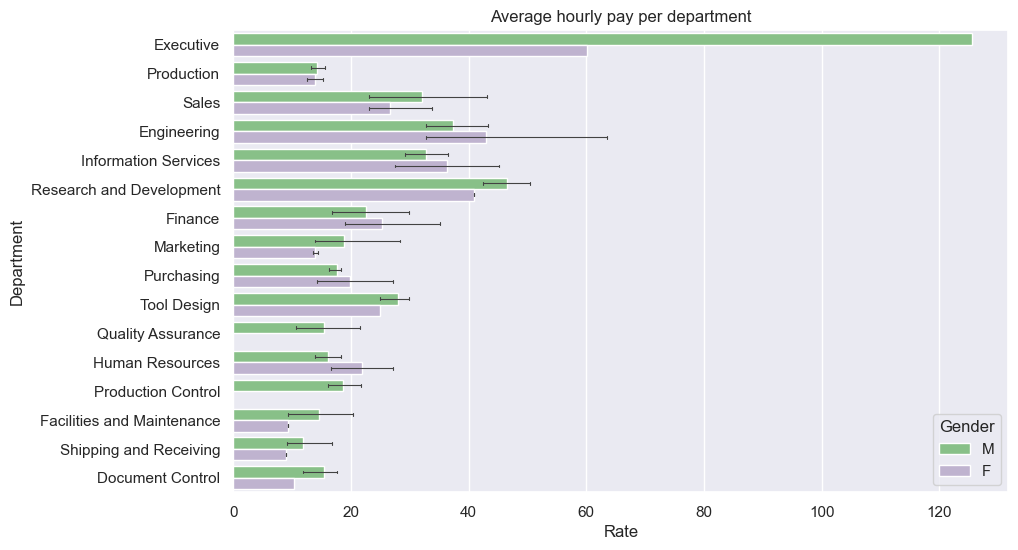

In [90]:
# Medel timlön uppdelat på avdelning och kön
gender_mean_hour_salary = employeedf.groupby(['Department', 'Gender'])['Rate'].mean()

sns.set(rc={"figure.figsize":(10, 6)})
sns.set_palette('Accent')

# Har med konfidens intervall för att det kan ge lite insikt i spridningen men den är inte i dessa fallen helt 
# korrekt pga hur seaborn räknar ut ci. Den behöver större dataset för att ge helt korrekta värden.
ax = sns.barplot(data=employeedf, x='Rate', y='Department', hue='Gender', errorbar='ci', capsize=0.1, errwidth=0.8)
ax.set_title('Average hourly pay per department')

[Text(0, 0, '17.7639'), Text(0, 0, '19.229')]

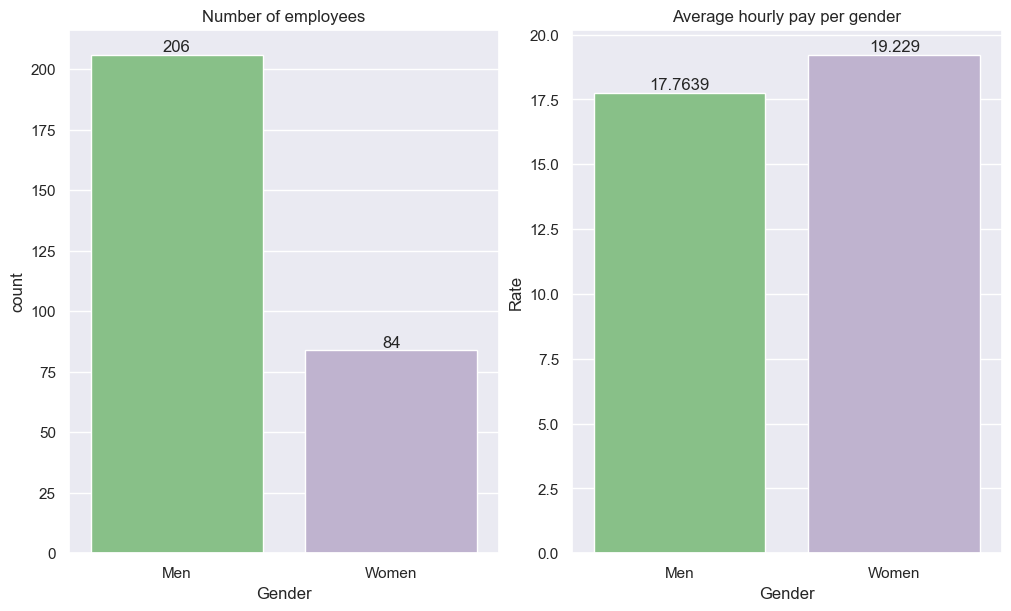

In [19]:
# Könsfördelningen på anställda
fig, ax = plt.subplots(1, 2, layout='constrained')
sns.countplot(data=employeedf, x='Gender', ax=ax[0])
ax[0].set_title('Number of employees')
ax[0].set_xticklabels(['Men', 'Women'])
ax[0].bar_label(ax[0].containers[0])

# Medel timlön fördelat på kön
sns.barplot(data=employeedf, x='Gender', y='Rate', ax=ax[1], errorbar=None)
ax[1].set_xticklabels(['Men', 'Women'])
ax[1].set_title('Average hourly pay per gender')
ax[1].bar_label(ax[1].containers[0])

c:\Users\marcu\anaconda3\envs\pyStat\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


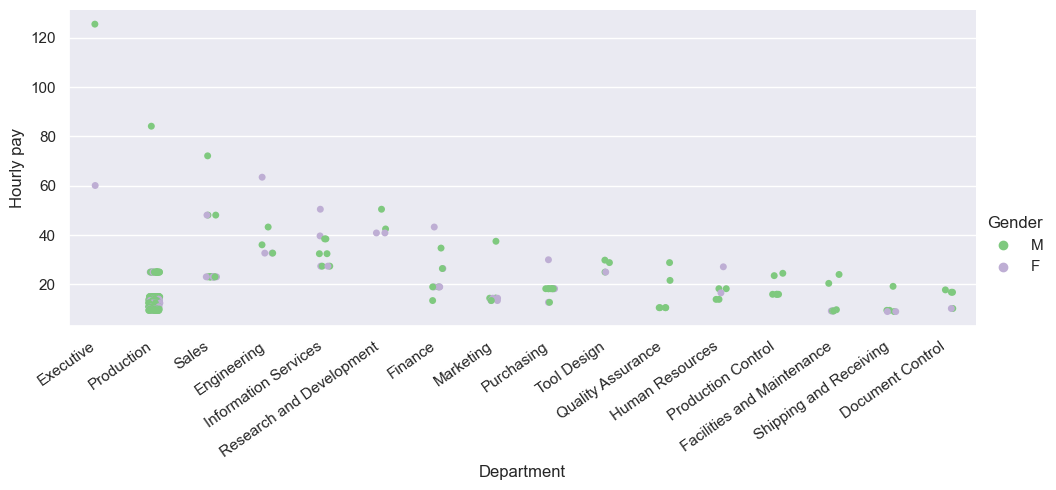

In [88]:
# Timlön för alla anställda indelat på avdelning.
employee_plot = sns.catplot(data=employeedf, x='Department', y='Rate', hue='Gender', height=4, aspect=2.5)
employee_plot.set_xticklabels(rotation = 35, ha = 'right')
employee_plot.set_ylabels('Hourly pay')

Text(0, 0.5, 'Hourly pay')

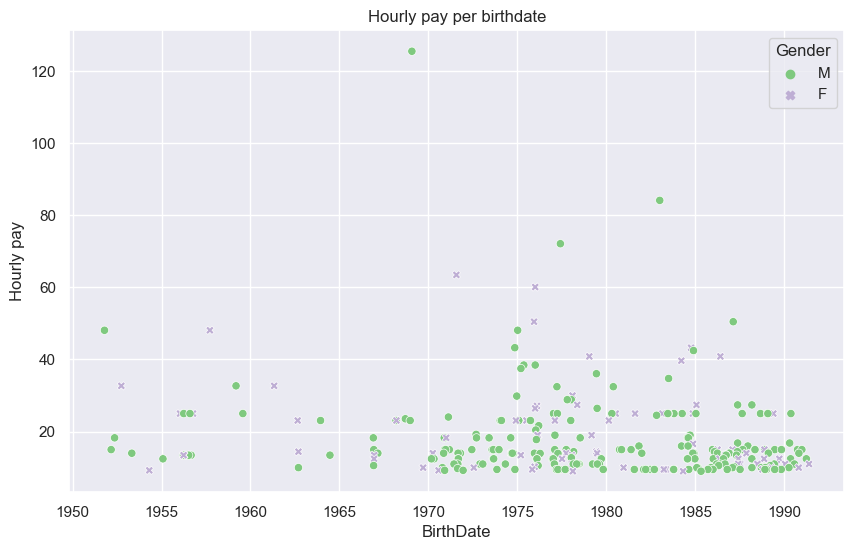

In [24]:
# Kollar om det finns något samband mellan ålder och lön.
employee_plot = sns.scatterplot(data=employeedf, x='BirthDate', y='Rate', hue='Gender', style='Gender')
employee_plot.set_title('Hourly pay per birthdate')
employee_plot.set_ylabel('Hourly pay')

In [29]:
dep_gender_pay = employeedf.groupby(['Department', 'Gender'])['Rate'].describe()

In [30]:
# Lägger till konfidens intervall gränserna i tabellen ovan.
ci95_hi = []
ci95_lo = []

for i in dep_gender_pay.index:
    c, m, std, min, perc25, perc50, perc75, max = dep_gender_pay.loc[i]
    ci95_lo.append(m - 1.96*std/np.sqrt(c))
    ci95_hi.append(m + 1.96*std/np.sqrt(c))

dep_gender_pay['ci95_lo'] = ci95_lo
dep_gender_pay['ci95_hi'] = ci95_hi

In [31]:
dep_gender_pay_ci = dep_gender_pay[['count', 'mean', 'std', 'ci95_lo', 'ci95_hi']]
dep_gender_pay_ci

count        mean        std    ci95_lo  \
Department                 Gender                                            
Document Control           F         1.0   10.250000        NaN        NaN   
                           M         4.0   15.423075   3.478380  12.014262   
Engineering                F         3.0   42.948700  17.764606  22.846156   
                           M         3.0   37.339733   5.403740  31.224825   
Executive                  F         1.0   60.096200        NaN        NaN   
                           M         1.0  125.500000        NaN        NaN   
Facilities and Maintenance F         2.0    9.250000   0.000000   9.250000   
                           M         5.0   14.544240   7.138936   8.286687   
Finance                    F         5.0   25.342300  10.526847  16.115112   
                           M         5.0   22.527880   8.237752  15.307172   
Human Resources            F         2.0   21.862950   7.462027  11.521108   
                           M         4.0   16.105750   2.498137  13.657576   
Information Services       F         4.0   36.237975  11.115718  25.344571   
                           M         6.0   32.772400   4.951381  28.810470   
Marketing                  F         4.0   13.942300   0.555180  13.398224   
                           M         5.0   18.846160  10.436123   9.698494   
Production                 F        46.0   13.821739   4.687153  12.467216   
                           M       133.0   14.264546   7.555014  12.980544   
Production Control         M         6.0   18.679483   4.162158  15.349063   
Purchasing                 F         4.0   19.822100   7.266986  12.700454   
                           M         8.0   17.579300   1.951332  16.227096   
Quality Assurance          M         6.0   15.464733   7.908155   9.136892   
Research and Development   F         2.0   40.865400   0.000000  40.865400   
                           M         2.0   46.480800   5.656854  38.640800   
Sales                      F         7.0   26.651771   9.458221  19.645023   
                           M        11.0   32.084782  16.627160  22.258758   
Shipping and Receiving     F         2.0    9.000000   0.000000   9.000000   
                           M         4.0   11.807700   4.954343   6.952444   
Tool Design                F         1.0   25.000000        NaN        NaN   
                           M         3.0   27.897467   2.558610  25.002127   

                                     ci95_hi  
Department                 Gender             
Document Control           F             NaN  
                           M       18.831888  
Engineering                F       63.051244  
                           M       43.454641  
Executive                  F             NaN  
                           M             NaN  
Facilities and Maintenance F        9.250000  
                           M       20.801793  
Finance                    F       34.569488  
                           M       29.748588  
Human Resources            F       32.204792  
                           M       18.553924  
Information Services       F       47.131379  
                           M       36.734330  
Marketing                  F       14.486376  
                           M       27.993826  
Production                 F       15.176262  
                           M       15.548547  
Production Control         M       22.009904  
Purchasing                 F       26.943746  
                           M       18.931504  
Quality Assurance          M       21.792575  
Research and Development   F       40.865400  
                           M       54.320800  
Sales                      F       33.658519  
                           M       41.910805  
Shipping and Receiving     F        9.000000  
                           M       16.662956  
Tool Design                F             NaN  
                           M       30.792806

In [32]:
# Lägger till en kategori i tabellen för att kunna visa lönfördelning för varje avdelning och kön.
cat = ['Document Control F', 'Document Control M', 
       'Engineering F', 'Engineering M', 
       'Executive F', 'Executive M', 
       'Facilities and Maintenance F', 'Facilities and Maintenance M', 
       'Finance F', 'Finance M', 
       'Human Resources F', 'Human Resources M', 
       'Information Services F', 'Information Services M', 
       'Marketing F', 'Marketing M', 
       'Production F', 'Production M', 
       'Production Control M', 
       'Purchasing F', 'Purchasing M', 
       'Quality Assurance M', 
       'Research and Development F', 'Research and Development M', 
       'Sales F', 'Sales M', 
       'Shipping and Receiving F', 'Shipping and Receiving M', 
       'Tool Design F', 'Tool Design M']

dep_gender_pay_ci['cat'] = cat

C:\Users\marcu\AppData\Local\Temp\ipykernel_6124\1421173956.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_gender_pay_ci['cat'] = cat


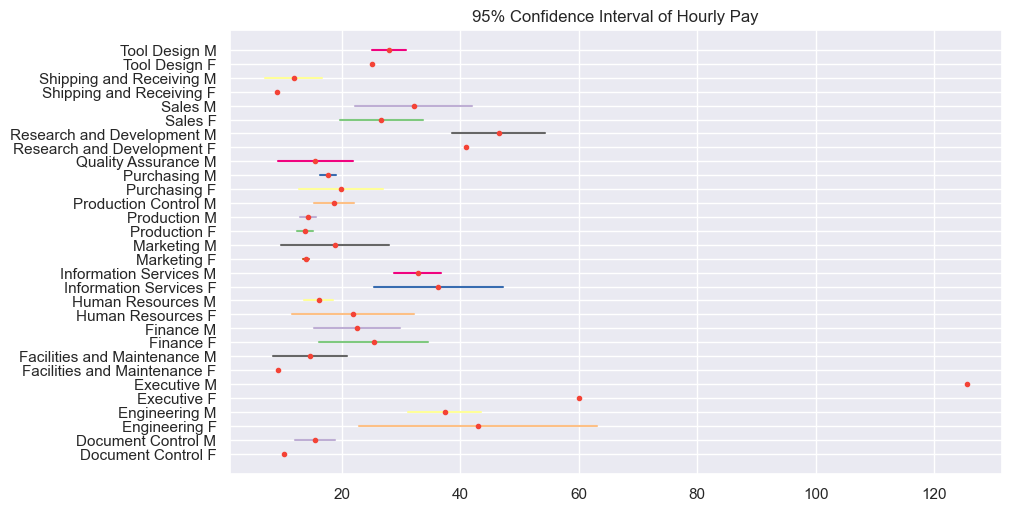

In [33]:
# Plottar konfidens intervall för varje avdelning och kön
fig, ax = plt.subplots(figsize=(10, 5),  layout='constrained')
ax.set_title('95% Confidence Interval of Hourly Pay')
for i in dep_gender_pay_ci.index:
    c, m, std, ci_lo, ci_hi, cat = dep_gender_pay_ci.loc[i]

    ax.plot([ci_lo, ci_hi], [cat, cat])
    # ax.plot([left, right], [top, top], color=color)
    # ax.plot([left, right], [bottom, bottom], color=color)
    ax.plot(m, cat, 'o',markersize=3, color='#f44336')

<Axes: xlabel='Rate', ylabel='Department'>

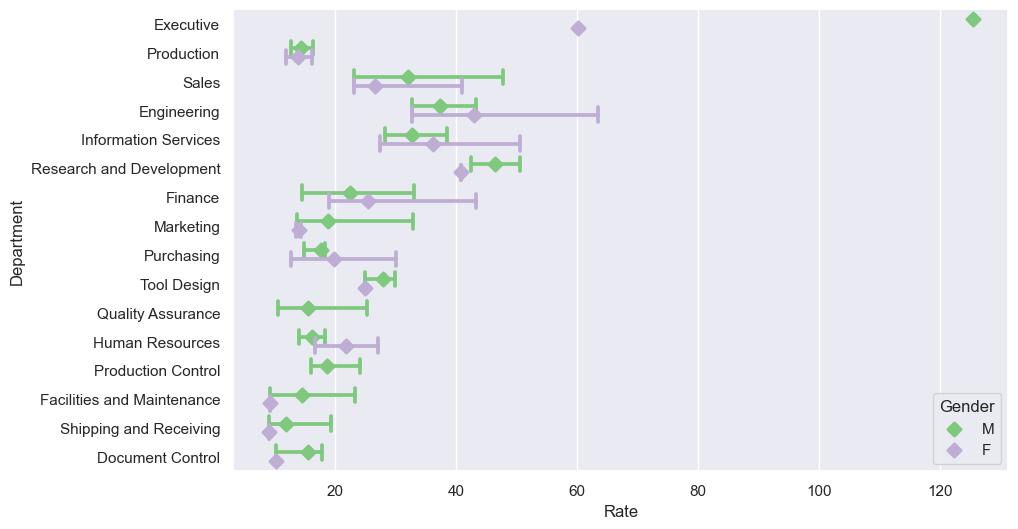

In [35]:
# Ville använda seaborn för att ha en snyggare visuallisering av konfidensintervallen men seaborn kan inte 
# ge en korrect uppskattning av konfidensintervall för dataset som är så här små.
sns.pointplot(
    data=employeedf, x="Rate", y="Department", hue='Gender',
    errorbar=("ci", 100), capsize=.5,
    linestyles='None', markers='D', dodge=.3
)

In [44]:
# Försäljning per kvartal
query_quarterly = """
SELECT YEAR(OrderDate) AS Year
	, DATEPART(qq, OrderDate) AS Quarter
	, CONCAT(YEAR(OrderDate), ' Q', DATEPART(qq, OrderDate)) AS YearQuarter
	, COUNT(SalesOrderID) AS NumberOfOrders
	, (COUNT(SalesOrderID) - LAG(COUNT(SalesOrderID)) OVER (ORDER BY CONCAT(YEAR(OrderDate), 'Q', DATEPART(qq, OrderDate))))
		AS OrderDiffPreviousQ
	, ROUND(SUM(TotalDue), 2) AS TotalSales
	, (SUM(TotalDue) - LAG(SUM(TotalDue)) OVER (ORDER BY CONCAT(YEAR(OrderDate), 'Q', DATEPART(qq, OrderDate))))
		AS SalesDiffPreviousQ
	, ROUND(AVG(TotalDue), 2) AS AvgTotal
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), DATEPART(qq, OrderDate)
ORDER BY YEAR(OrderDate), DATEPART(qq, OrderDate);
"""

quarterlydf = pd.read_sql(sql=query_quarterly, con=connection)

In [45]:
quarterlydf

,Year,Quarter,YearQuarter,NumberOfOrders,OrderDiffPreviousQ,TotalSales,SalesDiffPreviousQ,AvgTotal
0,2011,2,2011 Q2,184,NaN,1074117.42,NaN,5837.59
1,2011,3,2011 Q3,638,454.0,5647550.66,4.573433e+06,8851.96
2,2011,4,2011 Q4,785,147.0,7434031.44,1.786481e+06,9470.10
3,2012,1,2012 Q1,859,74.0,9443736.82,2.009705e+06,10993.87
4,2012,2,2012 Q2,952,93.0,9935495.17,4.917584e+05,10436.44
5,2012,3,2012 Q3,1022,70.0,10164406.83,2.289117e+05,9945.60
6,2012,4,2012 Q4,1082,60.0,8132061.49,-2.032345e+06,7515.77
7,2013,1,2013 Q1,1166,84.0,8771886.36,6.398249e+05,7523.06
8,2013,2,2013 Q2,1575,409.0,12225061.38,3.453175e+06,7761.94
9,2013,3,2013 Q3,5320,3745.0,14339319.19,2.114258e+06,2695.36


In [38]:
# Försäljning per år men från Q2 till Q2 eftersom databasen bara har data från Q2 2011 till Q2 2014 alltså totalt 3 år.
avg_sales_year = quarterlydf['TotalSales'].sum() / 3
print(f'Average sales per year: ${avg_sales_year:.2f}')
avg_increase_year = quarterlydf['SalesDiffPreviousQ'].sum() / 3
print(f'Average increase of sales per year: ${avg_increase_year:.2f}')

avg_sales_quart = quarterlydf['TotalSales'].mean()
print(f'Average sales per quarter: ${avg_sales_quart:.2f}')
avg_increase_quart = quarterlydf['SalesDiffPreviousQ'].mean()
print(f'Average sales increase per quarter: ${avg_increase_quart:.2f}')

avg_order_year = quarterlydf['NumberOfOrders'].sum() / 3
print(f'Average number of orders per year: {avg_order_year:.2f}')

avg_order_inc_year = quarterlydf['OrderDiffPreviousQ'].sum() / 3
print(f'Average increase of number of orders per year: {avg_order_inc_year:.2f}')

Average sales per year: $41072262.04
Average increase of sales per year: $2324034.47
Average sales per quarter: $9478214.32
Average sales increase per quarter: $581008.62
Average number of orders per year: 10488.33
Average increase of number of orders per year: 1760.33


C:\Users\marcu\AppData\Local\Temp\ipykernel_6124\2931077151.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['{:,.1f}'.format(y) + 'M' for y in ax[1].get_yticks()/1000000])


Text(0.5, 1.0, 'Average order amount per quarter')

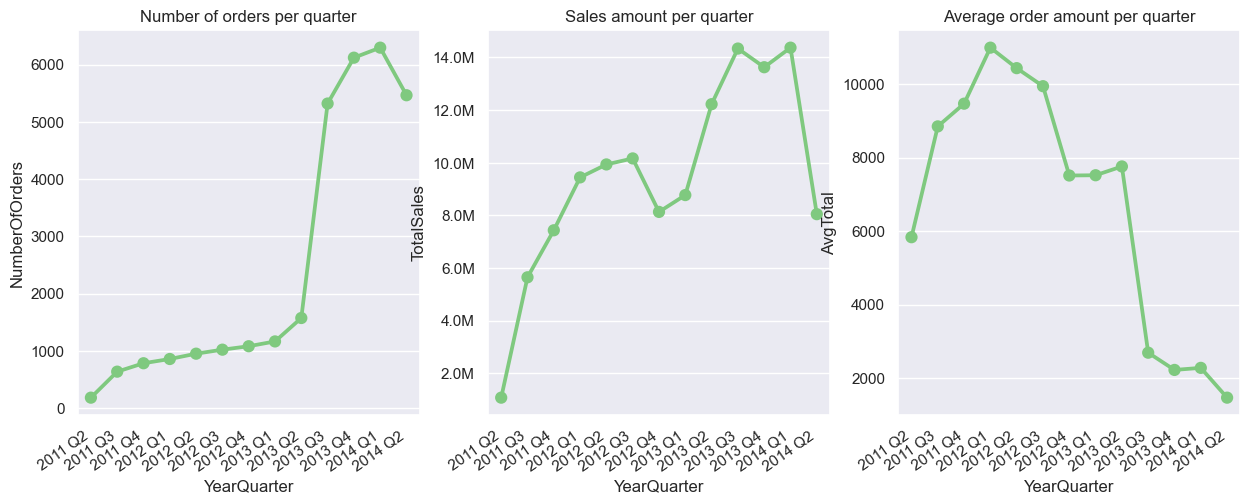

In [60]:
# Plottar antal ordrar tillsammans med försäljning för att kunna jämföra.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.pointplot(data=quarterlydf, x='YearQuarter', y='NumberOfOrders', ax=ax[0])
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation = 35, ha = 'right')
ax[0].set_title('Number of orders per quarter')

sns.pointplot(data=quarterlydf, x='YearQuarter', y='TotalSales', ax=ax[1])
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation = 35, ha = 'right')
ax[1].set_yticklabels(['{:,.1f}'.format(y) + 'M' for y in ax[1].get_yticks()/1000000])
ax[1].set_title('Sales amount per quarter')

sns.pointplot(data=quarterlydf, x='YearQuarter', y='AvgTotal', ax=ax[2])
ax[2].set_xticklabels(labels=ax[2].get_xticklabels(), rotation = 35, ha = 'right')
# ax[2].set_yticklabels(['{:,.1f}'.format(y) + 'M' for y in ax[2].get_yticks()/1000000])
ax[2].set_title('Average order amount per quarter')

In [67]:
# Kundinfo från undersökningsenkät.
customer_survey_query = """
SELECT vDem.BusinessEntityID
	, vDem.BirthDate
	, vDem.MaritalStatus
	, vDem.YearlyIncome
	, vDem.Gender
	, vDem.TotalChildren
	, vDem.NumberChildrenAtHome AS ChildrenAtHome
	, vDem.Education
	, vDem.Occupation
	, vDem.NumberCarsOwned AS CarsOwned
	, SUM(SOH.TotalDue) AS TotalOrderAmount
	, AVG(SOH.TotalDue) AS AvgOrderTotal
FROM Sales.vPersonDemographics AS vDem
	JOIN Sales.SalesOrderHeader AS SOH
		ON vDem.BusinessEntityID = SOH.CustomerID
GROUP BY vDem.BusinessEntityID
	, vDem.BirthDate
	, vDem.MaritalStatus
	, vDem.YearlyIncome
	, vDem.Gender
	, vDem.TotalChildren
	, vDem.NumberChildrenAtHome
	, vDem.Education
	, vDem.Occupation
	, vDem.NumberCarsOwned;
  """

customer_survey_df = pd.read_sql(sql=customer_survey_query, con=connection)

In [68]:
customer_survey_df

,BusinessEntityID,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,ChildrenAtHome,Education,Occupation,CarsOwned,TotalOrderAmount,AvgOrderTotal
0,11596,1936-02-27,M,greater than 100000,F,2,3,Graduate Degree,Management,3,55.2169,55.2169
1,13076,1953-05-18,M,greater than 100000,M,0,5,Bachelors,Management,3,7582.6629,2527.5543
2,20523,1955-02-12,M,greater than 100000,F,3,4,Partial High School,Professional,4,16.5529,16.5529
3,12604,1966-03-01,M,50001-75000,F,0,0,Graduate Degree,Professional,0,26.4869,26.4869
4,13877,1967-06-18,M,25001-50000,F,1,1,Bachelors,Clerical,1,3348.1860,1674.0930
...,...,...,...,...,...,...,...,...,...,...,...,...
9773,11050,1951-08-12,M,50001-75000,F,2,1,Partial College,Professional,2,5533.0666,1844.3555
9774,15304,1972-03-05,S,75001-100000,M,0,5,High School,Management,3,5351.5150,2675.7575
9775,18612,1962-10-05,S,50001-75000,F,1,0,Bachelors,Professional,1,132.5779,132.5779
9776,20196,1969-10-23,S,0-25000,M,2,2,High School,Manual,0,1238.1415,1238.1415


[Text(0, 0, '1087.58'), Text(0, 0, '1138.14')]

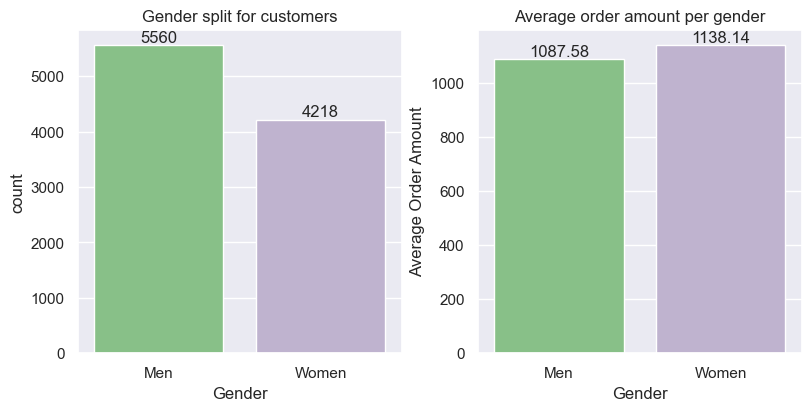

In [86]:
# Könsfördelning bland kunder som uppgav sitt kön i undersökningen.
fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout='constrained')
sns.countplot(data=customer_survey_df, x='Gender', ax=ax[0], order=customer_survey_df['Gender'].value_counts().index)
ax[0].set_title('Gender split for customers')
ax[0].set_xticklabels(['Men', 'Women'])
ax[0].bar_label(ax[0].containers[0])

# Medel total beställningsvärde över 3 år för varje kön
sns.barplot(data=customer_survey_df, x='Gender', y='AvgOrderTotal', ax=ax[1], errorbar=None, order=customer_survey_df['Gender'].value_counts().index)
ax[1].set_xticklabels(['Men', 'Women'])
ax[1].set_title('Average order amount per gender')
ax[1].set_ylabel('Average Order Amount')
ax[1].bar_label(ax[1].containers[0])

In [94]:
order_males = customer_survey_df[customer_survey_df['Gender']=='M'].AvgOrderTotal

# Räknar ut konfidensintervall för medel ordervärde för män.
ci = st.norm.interval(0.95, loc=np.mean(order_males), scale=st.sem(order_males))
ci

(1057.063411101254, 1118.0977764167317)

In [70]:
# kollar alla ordrar med kön på den som beställt
order_query = """
SELECT vDem.BusinessEntityID
	, vDem.Gender
	, SOH.TotalDue AS OrderAmount
FROM Sales.vPersonDemographics AS vDem
	JOIN Sales.SalesOrderHeader AS SOH
		ON vDem.BusinessEntityID = SOH.CustomerID
"""
orderdf = pd.read_sql(sql=order_query, con=connection)

In [71]:
orderdf

,BusinessEntityID,Gender,OrderAmount
0,11013,M,82.8529
1,11013,M,43.0729
2,11028,F,820.2968
3,11028,F,3729.3640
4,11028,F,2604.7944
...,...,...,...
17458,20730,F,76.2119
17459,20747,F,77.3390
17460,20748,F,136.9979
17461,20762,F,136.9979


In [80]:
order_gender_stats = orderdf.groupby('Gender')['OrderAmount'].describe()
order_gender_stats

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,7955.0,1260.518554,1348.765388,2.5305,51.3494,672.9008,2585.6669,3953.9884
M,9508.0,1234.455569,1284.669895,2.5305,55.2390,772.5036,2564.2216,3953.9884


In [81]:
ci95_hi = []
ci95_lo = []

for i in order_gender_stats.index:
    c, m, std, min, perc25, perc50, perc75, max = order_gender_stats.loc[i]
    ci95_lo.append(m - 1.96*std/np.sqrt(c))
    ci95_hi.append(m + 1.96*std/np.sqrt(c))

order_gender_stats['ci95_lo'] = ci95_lo
order_gender_stats['ci95_hi'] = ci95_hi

In [82]:
order_gender_ci = order_gender_stats[['count', 'mean', 'std', 'ci95_lo', 'ci95_hi']]
order_gender_ci

,count,mean,std,ci95_lo,ci95_hi
Gender,,,,,
F,7955.0,1260.518554,1348.765388,1230.878950,1290.158157
M,9508.0,1234.455569,1284.669895,1208.632787,1260.278351


In [77]:
gender = ['Women', 'Men']

order_gender_ci['gender'] = gender

C:\Users\marcu\AppData\Local\Temp\ipykernel_6124\90218897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_gender_ci['gender'] = gender


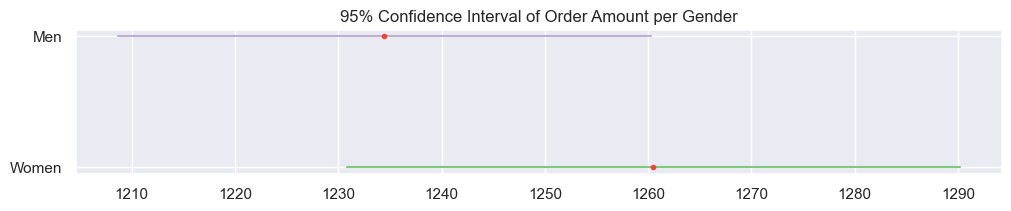

In [79]:
fig, ax = plt.subplots(layout='constrained')
ax.set_title('95% Confidence Interval of Order Amount per Gender')
for i in order_gender_ci.index:
    c, m, std, ci_lo, ci_hi, gender = order_gender_ci.loc[i]

    ax.plot([ci_lo, ci_hi], [gender, gender])
    ax.plot(m, gender, 'o',markersize=3, color='#f44336')
# Vet inte varför Men och Women är så brett imellan i grafen